# A Quick Hands-On Tutorial on LSTM for Multi-Input Time-Series Regression

In this notebook, you can find a brief tutorial on how to use LSTM for a simple regression problem. The following topics will be covered and hopefully at the end you will be able to use it for your own applications:
* Understanding the time-series models with multiple input features
* Very brief overview of LSTM units
* Creating a neural network model based on LSTMs
* Training an LSTM based neural network
* using the model to predict the output using the time-series inputs


The tutorial will cover the implementation using Keras (and TensorFlow as the backend).
You will be walked through all of the above via a simple regression example.

## Understanding a time-series model

In a usual regression problem, the real-valued output is a function of a number of input feature values. in a time-series, the output value depends on both the input feature values and the state at the previous time step.

In below, we randomly generate a time-series with two input values.
As you can see, the output value at time `t`, `Y[t]` is a function of the input value at time `t` and `t-1` i.e. `X1[t]` and `X1[t-1]`.

Although this is a very simple case and you can predict the value of `Y[t]` from `X1[t]`, in some cases the time dependency should also be used. 
For the purpose of this tutorial, we focus on predicting the `Y[t]` from `X[t],...,X[t-T]` where `T` is the size of time window used for the prediction.

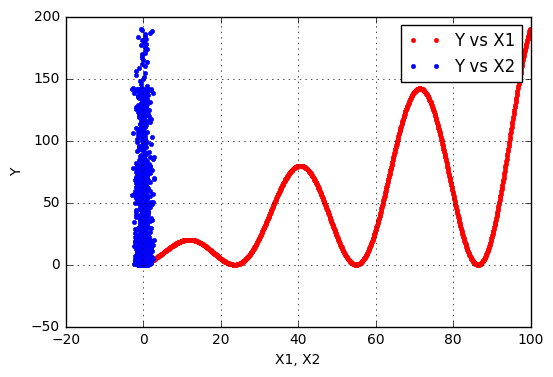

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Y = np.zeros(1000)
X1 = np.zeros(1000)
X2 = np.random.randn(1000)
for t in range(1000):
    X1[t] = t / 10
    Y[t] =  np.sin(X1[t]/5) * X1[t]
    if t > 0:
        Y[t] += X1[t-1]

X = np.stack((X1, X2), axis = 1)

plt.plot(X1, Y, 'r.')
plt.plot(X2, Y, 'b.')
plt.xlabel('X1, X2')
plt.ylabel('Y')
plt.legend(['Y vs X1', 'Y vs X2'])
plt.grid(True)

## Overview of LSTM

The Long-Short Term Memory (LSTM) is a special structure (shown in figure below) of the recurrent networks where the long term memory problem (caused as a result of fading gradients) is addressed by gating the feedback path.
The LSTM is now widely used in natural language processing applications where a sequence of input features is available. 

Taken from [this complete introduction to LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/),
an unrolled version of an LSTM unit is shown below.

[<img src="LSTM3-chain.png" width="550"/>](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)




## Creating a neural network model based on LSTMs using Keras

Keras is a wrapper package for Theano and TensorFlow which makes it easier to implement complicated network structures by providing a very abstract API. 
Using the `Sequential` API in Keras, we can make a neural network by adding different layers together:
```python
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(timesteps, 2)),
    LSTM(60),
    Dense(1),
])

```
In the above example, a sequential model is built by adding two LSTM layers and a dense layer together.
Keras has a rich list of layers including [Densely connected](https://keras.io/layers/core/), [Convolutional](https://keras.io/layers/convolutional/), [Recurrent](https://keras.io/layers/recurrent/), [Embedding](https://keras.io/layers/embeddings/) and etc.

### LSTM Layer
The implementation of LSTM in Keras includes the following arguments:
* `return_sequences`: This specifies if the layer should return a sequence of output values or only the values for the last time step. In case there is another recurrent layer after this layer, you need to set this option True so that the next recurrent layer receives a sequence as its input (see the example above)
* `stateful`: This option will determine if the inner state of LSTM for the previous batch is used as initial value for the state of LSTM in the current batch of sample. This will be discussed in the following section.
* `input_shape`: This is the dimension of the input to the layer and has to be set if this is the very first layer of the network. If your problem is such that you have `num_features` input values for each time step and you have `time_steps` previous time steps for prediction of the current output, your input shape should be `[time_steps, num_features]`.
* `input_length1`/`input_dim`: This is an alternative way to represent the input shape of the layer. The length will determine the length of the time-sequence and the dimension will specify the number of input features.
* `output_dim`: This determines the number of output values from this layer. Essentially, this is exactly the number of units in the LSTM layer. 
* `init`/`inner_init`: This is the function which initializes the weights and inner cells (states), respectively. The default valut is `glorot_uniform` for weights and you can pick one from [this list](https://keras.io/initializations/).
* `activation`: the activation function.
* `inner_activation`: the activation function for the inner cells.

The `compile` method will finally create the necessary tensors for the calculations of the model.
You can specify your own loss and optimization algorithm for the training stage when calling the `compile` method. 
In our case of regression, the mean squared error is an appropriate loss function and we plan to use the ADAM algorithm for training of our model.
To get familir with different optimization algorithms for training, you can read [this article](http://sebastianruder.com/optimizing-gradient-descent/index.html).

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM

timesteps = 5

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(timesteps, 2)),
    LSTM(60),
    Dense(1),
])

model.compile(loss='mean_squared_error', optimizer='adam')

Using TensorFlow backend.


## Training the LSTM based networks

To train the network using the training set, we need to put them in the right format.
In our example, we had a matrix `X` of size `1000x2` where the rows are the timesteps and the columns are the input feature values.

However, as you can see the input shape of our network has to be of the form `timesteps x num_features` for each sample.
Specifically, for each output value `Y[t]`, you need to provide the matrix `X[t-timesteps:t, :]` as the input to the network.
The network will consider the time dependency of input features (in a time window specified by `timesteps`) and will adjust its coefficients to produce `Y[t]`. 
Essentially, for each time step, `t`, which is part of the training set, we should provide a matrix of size `timesteps x num_features`. 
As a result, the final training features will have a shape of `num_samples x timesteps x num_features`.
It should be noted that in our example, `num_samples` is the same as the total number of timesteps `tot_timesteps`; i.e. `1000` (assuming that we have not separated some of them for cross validation or testing). 
In cases where you have multiple sequences for training, you only need to concatenate them along the first axis, resulting on a bigger `num_samples`.
For instance if you have `X{1}` through `X{m}` different sequences of size `tot_timesteps{i} x num_features`, the final training features will have a size of `num_samples x timesteps x num_features` where 

```
num_samples = sum( tot_timesteps{i} )
```
In the following snippet, we reformat the training set to the described shape:

```python
lstmTrainX = np.zeros([trainXscaled.shape[0], timesteps, 2])
lstmTrainY = np.zeros(trainXscaled.shape[0])

for i in range(timesteps, trainXscaled.shape[0]):
    lstmTrainX[i, :, :] = trainX[i-timesteps:i,:]
    lstmTrainY[i] = trainY[i]

```

Finally, the `fit` API in keras will train the network using the provided matrices:
```python
hist = model.fit(lstmTrainX, lstmTrainY, nb_epoch=100, batch_size=batch_size_, verbose = 1, validation_split=0.2, shuffle=True)
```
In this function, the following arguments may be provided:
* `nb_epoch`: the number of epoches at which the training should stop
* `batch_size`: the mini-batch size used in the optimization process. a smaller size will result in faster convergence but will increase the computation time.
* `shuffle`: specifies if the sample should be shuffled after each epoch. It should be noted that this does not shuffle the samples before drawing a subset of them for cross validation and you need to shuffle them before passing it to fit.
* `validation_split`: if this option is provided, a cross-validation set will be drawn from the samples and cross-validation will be done on them at each epoch. You can see the cross-validation error along the training set error in the return value of the fit function.
* `callbacks`: This option will provide the ability to have an early stopping (or other) mechanisms. In case of early stopping, you need to create an instance of early stopping `keras.callbacks.EarlyStopping()` created and passed in as: `callbacks=[early_stop_instance]`

As a final note, it should be mentioned that the calculations both during the fitting (training) and prediction will be overlapping as a result of feeding the network with the time window of input features separately.
In other words, the computation of each input set ( matrix of size `timesteps x num_features` ) does not take into account the overlap of time samples for different input sets.


### Feature Scaling

It is very important to apply feature scaling on the input values as the optimization of weights in a recurrent neural network is sensitive to it.
This can be easily done by using sklearn preprocessing package:
```python
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit( trainX )
trainXscaled = scaler.transform(trainX)
```

In below, you can see the complete code for feature scaling, re-formatting of the inputs and fitting the network.

Train on 640 samples, validate on 160 samples
Epoch 1/100
19s - loss: 1135.0462 - val_loss: 1060.3026
Epoch 2/100
19s - loss: 1069.7883 - val_loss: 1222.1530
Epoch 3/100
19s - loss: 1103.2247 - val_loss: 1051.5998
Epoch 4/100
19s - loss: 1059.4084 - val_loss: 1055.6410
Epoch 5/100
18s - loss: 1028.4226 - val_loss: 1107.8860
Epoch 6/100
18s - loss: 1095.1002 - val_loss: 1059.3206
Epoch 7/100
18s - loss: 1038.5671 - val_loss: 1075.8011
Epoch 8/100
18s - loss: 1054.9699 - val_loss: 1057.5776
Epoch 9/100
15s - loss: 1033.2374 - val_loss: 1060.0399
Epoch 10/100
18s - loss: 1044.5332 - val_loss: 1279.1485
Epoch 11/100
18s - loss: 1068.0937 - val_loss: 1058.2995
Epoch 12/100
18s - loss: 1021.7151 - val_loss: 1239.1024
Epoch 13/100
19s - loss: 1064.0393 - val_loss: 1059.2356
Epoch 14/100
19s - loss: 1034.8724 - val_loss: 1062.8306
Epoch 15/100
18s - loss: 1019.1429 - val_loss: 1082.3491
Epoch 16/100
18s - loss: 1254.7893 - val_loss: 1095.9248
Epoch 17/100
18s - loss: 1036.7011 - val_loss: 1075

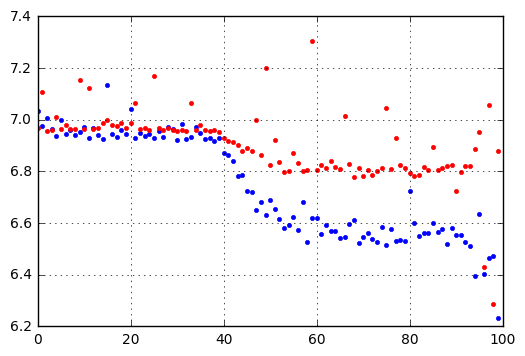

In [5]:
trainX = X
trainY = Y

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit( trainX )
trainXscaled = scaler.transform(trainX)

lstmTrainX = np.zeros([trainXscaled.shape[0], timesteps, 2])
lstmTrainY = np.zeros(trainXscaled.shape[0])

for i in range(timesteps, trainXscaled.shape[0]):
    lstmTrainX[i, :, :] = trainX[i-timesteps:i,:]
    lstmTrainY[i] = trainY[i]

from sklearn.utils import shuffle
lstmTrainX, lstmTrainY = shuffle(lstmTrainX, lstmTrainY)

#Split to Training and Test Sets (Test used later for prediction test)
lstmTestX = lstmTrainX[800:,:,:]
lstmTestY = lstmTrainY[800:]
lstmTrainX = lstmTrainX[0:800,:,:]
lstmTrainY = lstmTrainY[0:800:]

batch_size_ = 1
hist = model.fit(lstmTrainX, lstmTrainY, nb_epoch=100, batch_size=batch_size_, verbose = 2, validation_split=0.2, shuffle=True)

plt.plot(np.log(hist.history['loss']), 'b.')
plt.plot(np.log(hist.history['val_loss']), 'r.')
plt.grid(True)
plt.legend(['training loss', 'validation loss'])
plt.show()

##  Prediction of time-series samples

To perform a prediction and get a single output value `Y[t]`, you need to provide a similar input matrix of size `timesteps, num_features` to the training inputs. 
Obviously, you need to have the time history of the input values, `X[t-timesteps:t, :]` to be able to have a prediction for `Y[t]`.
The `predict` function of the trained model will perform the prediction and return a vector of predicted values for each set of time inputs. 

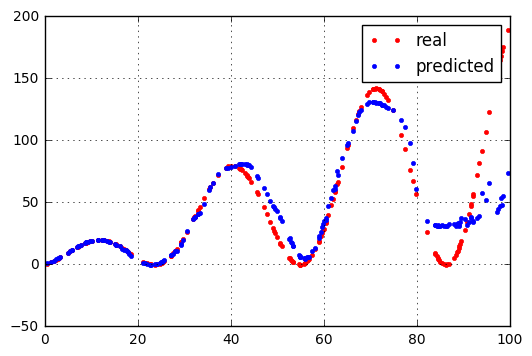

In [7]:
predY = model.predict(lstmTestX)
plt.plot(lstmTestX[:, -1, 0], lstmTestY, 'r.')
plt.plot(lstmTestX[:, -1, 0], predY, 'b.')
plt.legend(['real', 'predicted'])
plt.grid(True)

## Stateful LSTM

To be continued...http://philipperemy.github.io/keras-stateful-lstm/